# Universidade Federal de São Carlos
# Programação Paralela e Distribuida - Atividade
Professores: Hélio

## **Atividade**: paralelização da multiplicação de matrizes usando OpenMP

O objetivo desta atividade é experimentar a aplicação de diretivas OpenMP para a paralelização do código de um programa que realiza a multiplicação de 2 matrizes.

Trata-se de um código em que o maior volume de processamento está relacionado à execução de um conjunto de laços, contendo iterações sem dependências entre si, com oportunidade de divisão das iterações entre múltiplas tarefas.

Como há 3 loops aninhados, o desafio é experimentar a divisão de iterações nesses 3 casos, estudando as implicações de cada um deles, incluindo compartilhamento ou não de variáveis, e observar os resultados obtidos.

In [5]:
# Pacote time --> /usr/bin/time (para formatação da saida)
!sudo apt install time
!whereis time

[sudo] password for mbgustav: 


time: /usr/bin/time /usr/share/man/man1/time.1.gz /usr/share/man/man7/time.7.gz /usr/share/man/man2/time.2.gz /usr/share/info/time.info.gz


# Versão sequencial de referência

O código a seguir, sequencial, serve como referência para as medidas de tempo para análise do *speedup* e da eficiênia da paralelização. 

In [6]:
# Para saber sobre o número de processadores existentes
! lscpu | grep CPU

CPU op-mode(s):                     32-bit, 64-bit
CPU(s):                             8
On-line CPU(s) list:                0-7
CPU family:                         6
CPU max MHz:                        4400,0000
CPU min MHz:                        400,0000
NUMA node0 CPU(s):                  0-7


In [36]:
%%writefile mult-serial.c

/* mult.c  - Para compilar, use: $ gcc mult-serial.c -o mult-serial -fopenmp */

#include <stdlib.h>
#include <stdio.h>
#include <time.h>

#define DIM 1024       // ajuste a dimensão aqui...

// matrizes estáticas
float A [DIM] [DIM];
float B [DIM] [DIM];
float C [DIM] [DIM];

int
main(int argc, char *argv[])
{
   int i,j,k;

   /* Atribuição de valores iniciais (0..1) às matrizes */
   srand(time(NULL));
   for(i=0; i < DIM; i++)
      for(j=0; j < DIM; j++) {
         A[i][j]= (float)rand() / (float)RAND_MAX;
         B[i][j]= (float)rand() / (float)RAND_MAX;
      }

   /* Multiplicação tradicional */

   for(i=0; i < DIM; i++)
      for(j=0; j < DIM; j++) {
         C[i][j] = 0;
         for(k=0; k < DIM; k++)
            C[i][j] = C[i][j] + A[i][k] * B[k][j]; 
      }

  return(0); 
}

Overwriting mult-serial.c


In [32]:
# Compila programa, se houve alteração no código fonte. 
# Ah, iportante indicar ao compilador para fazer as otimizações de vetorização, usando -O3
! if [ ! mult-serial -nt mult-serial.c ]; then gcc mult-serial.c -o mult-serial -O3; fi
# Executa programa, medindo tempos de execução: real = tempo decorrido
! time ./mult; rm mult-serial


real	0m39,787s
user	0m39,531s
sys	0m0,186s


# Versão paralela

A ideia é alterar o código a seguir, inserindo diretivas OpenMP para paralelização apoiada pelo compilador. 
## Paralelismo no 1º loop

In [37]:
%%writefile mult-ext.c
// Multiplicação com parallel for no loop mais externo

/* mult.c  - Para compilar, use: $ gcc mult.c -o mult -fopenmp */

#include <stdlib.h>
#include <stdio.h>
#include <time.h>
#include <omp.h>
#define DIM 1024       // ajuste a dimensão aqui...

// matrizes estáticas
float A [DIM] [DIM];
float B [DIM] [DIM];
float C [DIM] [DIM];

int
main(int argc, char *argv[])
{
  int i,j,k;

  /* Atribuição de valores iniciais (0..1) às matrizes */
  srand(time(NULL));
  for(i=0; i < DIM; i++)
    for(j=0; j < DIM; j++) {
      A[i][j] = (float)rand() / (float)RAND_MAX;
      B[i][j] = (float)rand() / (float)RAND_MAX;
    }

  #pragma omp parallel for private(i, j, k) shared(A,B,C)
  for(i=0; i < DIM; i++)
    for(j=0; j < DIM; j++) {
      C[i][j] = 0;
      for(k=0; k < DIM; k++)
        C[i][j] = C[i][j] + A[i][k] * B[k][j]; 
    }

  return(0); 
}

Writing mult-ext.c


## Paralelismo 2º Loop

In [38]:
%%writefile mult-mid.c
// Multiplicação com parallel for no loop intermediario
/* mult.c  - Para compilar, use: $ gcc mult.c -o mult -fopenmp */

#include <stdlib.h>
#include <stdio.h>
#include <time.h>
#include <omp.h>
#define DIM 1024       // ajuste a dimensão aqui...

// matrizes estáticas
float A [DIM] [DIM];
float B [DIM] [DIM];
float C [DIM] [DIM];

int
main(int argc, char *argv[])
{
  int i,j,k;

  /* Atribuição de valores iniciais (0..1) às matrizes */
  srand(time(NULL));
  for(i=0; i < DIM; i++)
    for(j=0; j < DIM; j++) {
      A[i][j] = (float)rand() / (float)RAND_MAX;
      B[i][j] = (float)rand() / (float)RAND_MAX;
    }

  /* Multiplicação tradicional */
  for(i=0; i < DIM; i++)
    #pragma omp parallel for private(j, k) shared(A,B,C)
    for(j=0; j < DIM; j++) {
      C[i][j] = 0;
      for(k=0; k < DIM; k++)
        C[i][j] = C[i][j] + A[i][k] * B[k][j]; 
    }

  return(0); 
}

Writing mult-mid.c


## Paralelismo 3º Loop

In [50]:
%%writefile mult-int.c
// Multiplicação com parallel for no loop mais interno --> uso do reduction

/* mult.c  - Para compilar, use: $ gcc mult.c -o mult -fopenmp */

#include <stdlib.h>
#include <stdio.h>
#include <time.h>
#include <omp.h>
#define DIM 1024       // ajuste a dimensão aqui...

// matrizes estáticas
float A [DIM] [DIM];
float B [DIM] [DIM];
float C [DIM] [DIM];

int
main(int argc, char *argv[])
{
  int i,j,k;

  /* Atribuição de valores iniciais (0..1) às matrizes */
  srand(time(NULL));
  for(i=0; i < DIM; i++)
    for(j=0; j < DIM; j++) {
      A[i][j] = (float)rand() / (float)RAND_MAX;
      B[i][j] = (float)rand() / (float)RAND_MAX;
    }


  for(i=0; i < DIM; i++)
    for(j=0; j < DIM; j++) {
      float sum = 0.0f;      
      #pragma omp parallel for
      for(k=0; k < DIM; k++)
        sum += A[i][k] * B[k][j]; 
      C[i][j] = sum;
    }

  return(0); 
}

Overwriting mult-int.c


In [52]:
# Que tal um script para experimentar o programa com diferentes números de threads?
#OBS-1: %e retorna o tempo real de execução do script desejado
#OBS-2: linha 9 --- é necessario recompilar o arquivo fonte para alterar EXPORT

!filename=Benchmark.csv; echo "num_threads;exec_type;real_time" > $filename;\
for tipo in {ext,mid,int}; do                          \
    for nt in {1,2,4,8,16,32}; do                      \
        export OMP_NUM_THREADS=$nt;                    \
        gcc mult-$tipo.c -o mult-$tipo -O3 -fopenmp;   \
        echo Usando $nt threads em mult-$tipo;         \
        env time --append --format "$nt;$tipo;%e"      \
             --output $filename                        \
             ./mult-$tipo;                             \
        done;                                          \
done;                                                  \
gcc mult-serial.c -o mult-serial -O3;                  \
env time --append --format "$nt;serial;%e"             \
             --output $filename                        \
             ./mult-serial;                            
!echo Benchmark finalizado!

Usando 1 threads em mult-ext
Usando 2 threads em mult-ext
Usando 4 threads em mult-ext
Usando 8 threads em mult-ext
Usando 16 threads em mult-ext
Usando 32 threads em mult-ext
Usando 1 threads em mult-mid
Usando 2 threads em mult-mid
Usando 4 threads em mult-mid
Usando 8 threads em mult-mid
Usando 16 threads em mult-mid
Usando 32 threads em mult-mid
Usando 1 threads em mult-int
^C
Usando 2 threads em mult-int
Benchmark finalizado!


[ 1  2  4  8 16 32]


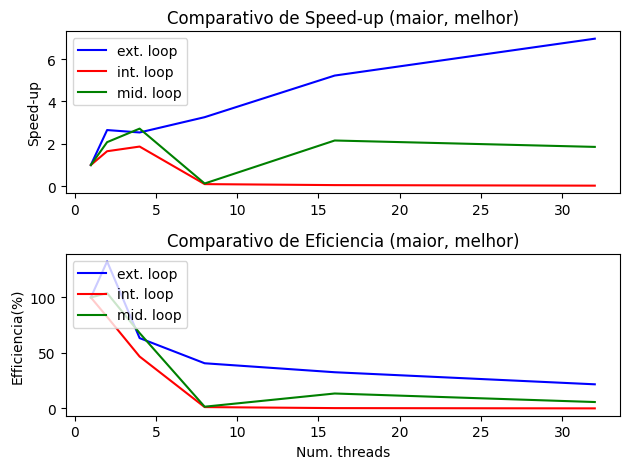

In [76]:
import matplotlib.pyplot as plt 
import pandas as pd


df = pd.read_csv('Benchmark.csv', sep=';')

df_ext = df[df['exec_type'] == 'ext']
df_int = df[df['exec_type'] == 'int']
df_mid = df[df['exec_type'] == 'mid']
print( df['num_threads'].unique())
# Get num_threads and real_time
num_threads = df['num_threads'].unique()

time_ext = df_ext.real_time.to_list()
time_int = df_int.real_time.to_list()
time_mid = df_mid.real_time.to_list()

#Speed up
t_ext = time_ext[0] #1 thread = sequencial
t_int = time_int[0] #1 thread = sequencial
t_mid = time_mid[0] #1 thread = sequencial

speed_up = lambda time, _t: [_t/x for x in time]
speed_up_ext = speed_up(time_ext, t_ext)
speed_up_int = speed_up(time_int, t_int)
speed_up_mid = speed_up(time_mid, t_mid)

#Eficiencia = speed_up / real_time
eff_ext = [float(spd/nt*100) for spd, nt in zip(speed_up_ext, num_threads)]
eff_int = [float(spd/nt*100) for spd, nt in zip(speed_up_int, num_threads)]
eff_mid = [float(spd/nt*100) for spd, nt in zip(speed_up_mid, num_threads)]


plt.figure()
plt.subplot(211)
plt.title("Comparativo de Speed-up (maior, melhor)")
plt.plot( num_threads, speed_up_ext,'b', label= "ext. loop")
plt.plot( num_threads, speed_up_int,'r', label= "int. loop" )
plt.plot( num_threads, speed_up_mid,'g', label= "mid. loop")
plt.legend(loc="upper left")
plt.ylabel("Speed-up") # ideal : spd > 1


plt.subplot(212)
plt.title("Comparativo de Eficiencia (maior, melhor)")
plt.plot( num_threads, eff_ext, 'b', label= "ext. loop")
plt.plot( num_threads, eff_int, 'r', label= "int. loop" )
plt.plot( num_threads, eff_mid, 'g', label= "mid. loop")
plt.legend(loc="upper left")
plt.xlabel("Num. threads")
plt.ylabel("Efficiencia(%)") # ideal se eff[i-1] > eff[i], que significa que a eficiencia deve aumentar proporcional ao nro. threads

plt.tight_layout()
plt.savefig('comparative-benchmark.png')
plt.show()


### Tabela de Dados de paralelização 
Segue abaixo um dataframe com os dados de paralelismo obtido no Colab - NUVEM

* Multiplicação - Paralelismo no loop Externo

In [ ]:
df_ext

* Multiplicação - Paralelismo no loop intermediário

In [ ]:
df_mid

* Multiplicação - Paralelismo no loop interno.

In [ ]:
df_int

### Execução em Máquina Local: 
resultado de $ __lscpu | grep CPU__:

```sh
CPU op-mode(s):                  32-bit, 64-bit
CPU(s):                          8
On-line CPU(s) list:             0-7
CPU family:                      6
CPU max MHz:                     4400,0000
CPU min MHz:                     400,0000
NUMA node0 CPU(s):               0-7
```


<img src='benchmark-local.png'>

In [77]:
# Clean Worskpace
!rm mult-* *.csv